In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation


In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper params

num_iterations = 50 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 5  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    


In [6]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [8]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation(acceptPol)
#print(eval_env)

init
12
15
10
14
1
17
11
16
3
8
2
7
5
9
13
4
18
0
6
19
0 completed 13
1 completed 13
2 completed 11
3 completed 15
4 completed 18
5 completed 10
6 completed 12
7 completed 10
8 completed 11
9 completed 9
10 completed 10
11 completed 13
12 completed 12
13 completed 18
14 completed 11
15 completed 12
16 completed 11
17 completed 15
18 completed 13
19 completed 13


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)

#evaluatePolicy(acceptPol, eval_env)

In [10]:
# compute average return
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation(policy)
        episode_reward = 0
        for state_list in state_lists:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


In [11]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation(policy)
        print("driver count : ", len(state_lists))
        for state_list in state_lists:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]

                #print (action)
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)

        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [12]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience).loss

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

9
1
11
13
18
17
4
3
15
10
12
7
14
0
5
16
6
2
19
8
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
18
10
5
8
16
12
2
15
6
9
3
13
7
14
1
4
19
17
11
0
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
6
19
13
17
1
2
10
15
0
8
5
3
18
14
12
16
7
9
11
4
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 complet

14
7
18
2
3
17
12
10
1
16
9
13
6
4
15
19
5
8
11
0
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
14
16
8
7
9
13
11
4
2
17
1
18
0
6
3
12
19
5
15
10
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
tf.Tensor(0.0, shape=(), dtype=float32)
step = 10: Average Return = 0.0
evaluation
4
18
12
5
19
0
16
13
8
10
1
2
11
14
9
17
7
15
3
6
0 completed 9
1 completed 14
2 completed 7
3 completed 6
4 completed 8
5 completed 6
6 completed 14
7 completed 4
8 completed 5
9 completed 7
10 completed 6
11 completed 6
12 completed 6


11
19
2
1
4
18
3
5
13
0
9
8
16
12
7
14
10
17
15
6
0 completed 9
1 completed 8
2 completed 7
3 completed 7
4 completed 14
5 completed 4
6 completed 8
7 completed 8
8 completed 9
9 completed 2
10 completed 7
11 completed 9
12 completed 8
13 completed 4
14 completed 5
15 completed 9
16 completed 13
17 completed 14
18 completed 4
19 completed 7
driver count :  20
13
3
5
1
12
2
10
7
0
8
6
11
15
18
9
4
16
19
17
14
0 completed 8
1 completed 8
2 completed 16
3 completed 4
4 completed 9
5 completed 7
6 completed 4
7 completed 8
8 completed 4
9 completed 5
10 completed 7
11 completed 10
12 completed 8
13 completed 8
14 completed 7
15 completed 5
16 completed 5
17 completed 9
18 completed 7
19 completed 14
driver count :  20
5
13
4
11
15
18
12
9
17
7
1
8
2
3
0
19
14
6
10
16
0 completed 7
1 completed 7
2 completed 4
3 completed 8
4 completed 8
5 completed 11
6 completed 8
7 completed 8
8 completed 5
9 completed 8
10 completed 8
11 completed 9
12 completed 8
13 completed 10
14 completed 13
15 compl

4
0
18
9
8
3
19
13
7
12
5
2
16
17
6
11
1
10
15
14
0 completed 3
1 completed 5
2 completed 11
3 completed 6
4 completed 6
5 completed 9
6 completed 5
7 completed 3
8 completed 11
9 completed 13
10 completed 7
11 completed 5
12 completed 12
13 completed 8
14 completed 14
15 completed 7
16 completed 8
17 completed 10
18 completed 14
19 completed 10
driver count :  20
19
15
7
10
4
11
1
8
9
17
3
13
5
6
14
2
16
0
18
12
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
6
13
4
19
7
9
0
8
5
17
15
14
10
12
3
11
1
18
2
16
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 

11
19
7
15
1
14
5
0
3
8
12
6
16
9
2
18
13
17
10
4
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
9
19
14
18
17
1
6
11
5
3
4
12
13
2
10
7
15
0
8
16
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 completed 0
19 completed 0
5
10
17
18
4
12
13
16
1
2
3
15
7
9
0
6
19
14
11
8
0 completed 0
1 completed 0
2 completed 0
3 completed 0
4 completed 0
5 completed 0
6 completed 0
7 completed 0
8 completed 0
9 completed 0
10 completed 0
11 completed 0
12 completed 0
13 completed 0
14 completed 0
15 completed 0
16 completed 0
17 completed 0
18 complet

Text(0.5, 0, 'Iterations')

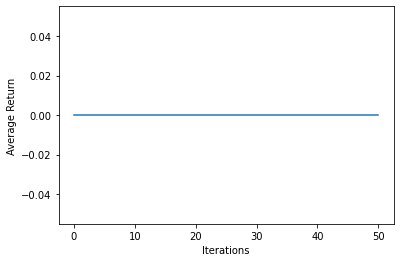

In [13]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [16]:
#run_simulation(eval_policy)
evaluatePolicy(acceptPol, eval_env)

-44
60
-8
-84
32
82
46
8
20
4
20
-46
driver reward  90
38
-56
-116
0
12
74
10
-100
-78
46
6
78
driver reward  -86
-8
-60
-34
-90
0
8
-84
-44
12
38
driver reward  -262
-24
-106
-188
-84
-22
-50
32
-88
20
74
-42
driver reward  -478
-28
-42
-18
-114
-10
-64
-22
-40
-38
22
50
20
-12
driver reward  -296
-22
20
-154
-18
56
-116
-36
-24
2
16
-20
-68
-114
-98
-116
driver reward  -692
10
-62
22
64
-36
38
-34
-92
44
8
-70
-42
-158
driver reward  -308
-34
22
0
-110
-96
12
-80
-68
-64
4
-16
driver reward  -430
40
-112
-38
-184
44
-14
-50
-100
32
-68
-58
-16
-84
72
36
driver reward  -500
62
102
-50
-116
-118
-60
-96
-124
-62
30
-48
driver reward  -480
-104
-36
-32
-130
-120
-74
-38
-56
10
14
-64
driver reward  -630
-78
34
-72
-64
70
-42
-78
4
-50
-74
driver reward  -350
-52
-12
10
44
-24
22
40
-144
-34
-152
driver reward  -302
-138
-62
70
-58
-20
-36
24
-38
-34
driver reward  -292
-30
-212
24
-168
-10
58
-136
-46
-98
58
-20
-32
86
38
-12
44
-16
-10
driver reward  -482
-64
54
8
-4
-82
-36
70
-174
-4

In [68]:
"""
reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################














SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-68-ff0ae3fb21d8>, line 19)

In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""